In [1]:
!pwd

/home/br/sweethome/ferm/worm_disord/analyze


In [2]:
import io

import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

## Read in the `res` lines

In [3]:
def read_res(fnames):
    """Read the `res_SUFFIX` files for a collection of replicas."""
    
    firstline = "replica_id density err_density conv_density g_im err_g_im conv_g_im Z(mln)"
    lines = [firstline]

    for fname in fnames:
        with open(fname, 'r') as f:
            line = f.read()
            #line.spline
        lines.append(" ".join(line.split()))

    lines
    buffer = io.StringIO("\n".join(lines))
    df = pd.read_csv(buffer, sep="\s+")
    return df

## Resample

In [4]:
def resample(mean, err, num_samples=100000, seed=1234):
    """Compute the replica average over a `mean` array w/synthetic datasets.
        
    Given two arrays of values and errorbars (one for each replica),
    generate `num_samples` synthetic realizations for each replica. For each realization,
    compute the average value.
    
    Parameters
    ----------
    mean : array_like, shape (n_meas,)
        Mean values, one for each replica.
    err : array_like, shape (n_meas,)
        Errorbars, one for each replica.
    num_samples : int
        Generate sythetic datasets of this many samples
        for each element of `mean` and arr.
    seed : int
        np.random seed for random numbers
        
    Returns
    -------
    ndarray, shape (n_samples,)
        Synthetic dataset: average over the replicas
        
    """
    mean, err = map(np.asarray, (mean, err))
    num_meas = mean.size
    synth = np.empty((num_meas, num_samples), dtype=float)
    
    rndm = np.random.RandomState(seed)
    for j in range(num_meas):
        synth[j, :] = rndm.normal(mean[j], err[j], size=num_samples)
        
    return synth.sum(axis=0) / num_meas

## Convergence analysis: plot `nmnm` distributions

In [24]:
def load_nmnm(fname):
    nmnm = np.loadtxt(fname)
    mask = nmnm[:, 1] > 0
    return nmnm[mask]

def overlay_gaussian(nm):
    """Cook up a gaussian shaped curve with sample 1st and 2nd moments.
    """
    x, y = nm.T
    m1 = (x * y).sum()
    m2 = ((x - m1)**2 * y).sum() 
    
    arr = np.exp(-(x - m1)**2 / 2 / m2)
    arr /= arr.sum()
    return arr 

In [49]:
def plot_nmnm(fnames, fname_unif):
    fig, axx = plt.subplots(len(fnames)//3+1, 3, figsize=(9, 15))

    for fname, ax in zip(fnames, axx.ravel()):
        nm = load_nmnm(fname)

        ax.plot(nm[:, 0], nm[:, 1], 'o')
        ax.plot(nm[:, 0], overlay_gaussian(nm), '-', lw=3)
        ax.set_title( fname.split("/nmnm_")[-1].split(".dat")[0])
        ax.grid(True)
        
        nm_unif = load_nmnm(fname_unif)
        ax.plot(nm_unif[:, 0], nm_unif[:, 1], '--', color='C4')
        
    plt.tight_layout()

# Process L=6


### Analyze $L=6$, $\beta = 3.5$

In [5]:
resdict_L6b35 = {"L": 6, "beta": 3.5}


reslines = !ls ../runs/L6b3.5/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b3.5/res_L6b3.5r10a0.1.dat', '../runs/L6b3.5/res_L6b3.5r1a0.1.dat', '../runs/L6b3.5/res_L6b3.5r2a0.1.dat', '../runs/L6b3.5/res_L6b3.5r3a0.1.dat', '../runs/L6b3.5/res_L6b3.5r4a0.1.dat', '../runs/L6b3.5/res_L6b3.5r5a0.1.dat', '../runs/L6b3.5/res_L6b3.5r6a0.1.dat', '../runs/L6b3.5/res_L6b3.5r7a0.1.dat', '../runs/L6b3.5/res_L6b3.5r8a0.1.dat', '../runs/L6b3.5/res_L6b3.5r9a0.1.dat']


,replica_id,density,err_density,conv_density,g_im,err_g_im,conv_g_im,Z(mln)
0,10,0.177601,0.000430,T,0.076570,0.000694,T,187.820970
1,1,0.169371,0.000412,T,0.070404,0.000408,T,319.558336
2,2,0.168192,0.000379,T,0.069945,0.000648,F,256.019088
3,3,0.171659,0.000410,T,0.072381,0.000572,T,322.923431
4,4,0.184929,0.000334,T,0.083769,0.000645,T,218.616277
5,5,0.163729,0.000312,T,0.066514,0.000375,T,368.362091
6,6,0.180920,0.000503,T,0.080947,0.000638,T,179.530532
7,7,0.159972,0.000315,T,0.063386,0.000330,T,396.708176
8,8,0.181314,0.000412,T,0.080763,0.000716,T,175.597718
9,9,0.159755,0.000274,T,0.062684,0.000394,T,409.722178


In [6]:
sum(df["g_im"])/len(df["g_im"])

0.07273627860259191

<IPython.core.display.Javascript object>


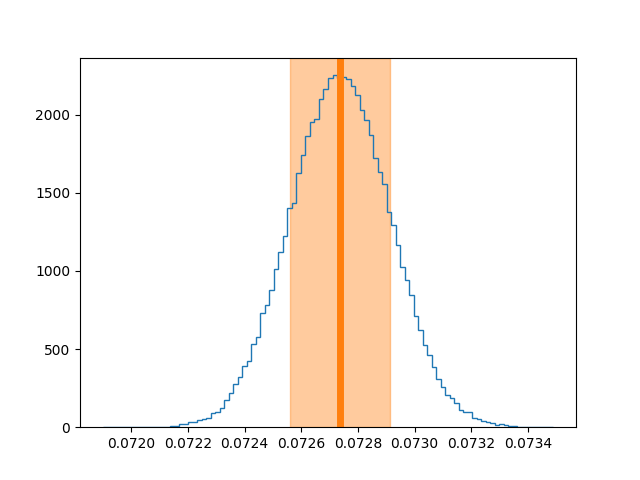

0.07273619241738194 +/- 0.0001769013784177102


In [7]:
samples = resample(df["g_im"], df["err_g_im"])

plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b35["g_im"] = m
resdict_L6b35["err_g_im"] = s

<IPython.core.display.Javascript object>


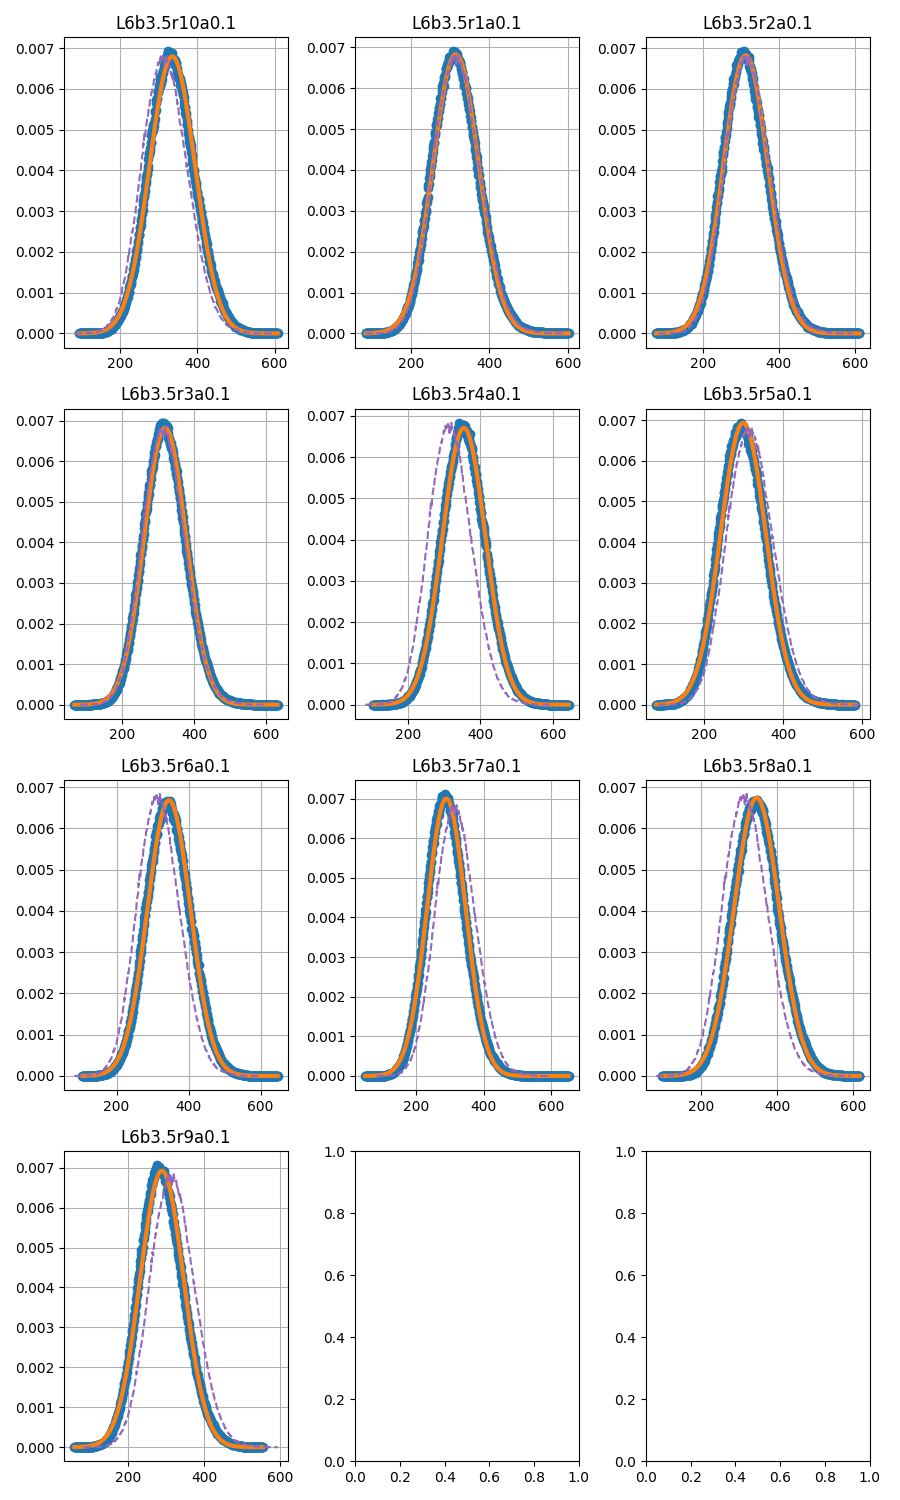

In [51]:
fnames = !ls ../runs/L6b3.5/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b3.5_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=6$, $\beta=4.0$

In [8]:
resdict_L6b40 = {"L": 6, "beta": 4.0}


reslines = !ls ../runs/L6b4.0/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b4.0/res_L6b4.0r10a0.1.dat', '../runs/L6b4.0/res_L6b4.0r1a0.1.dat', '../runs/L6b4.0/res_L6b4.0r2a0.1.dat', '../runs/L6b4.0/res_L6b4.0r3a0.1.dat', '../runs/L6b4.0/res_L6b4.0r4a0.1.dat', '../runs/L6b4.0/res_L6b4.0r5a0.1.dat', '../runs/L6b4.0/res_L6b4.0r6a0.1.dat', '../runs/L6b4.0/res_L6b4.0r7a0.1.dat', '../runs/L6b4.0/res_L6b4.0r8a0.1.dat', '../runs/L6b4.0/res_L6b4.0r9a0.1.dat']


,replica_id,density,err_density,conv_density,g_im,err_g_im,conv_g_im,Z(mln)
0,10,0.175660,0.000326,T,0.128410,0.001170,T,139.880731
1,1,0.166466,0.000363,T,0.112788,0.001126,F,141.410676
2,2,0.165304,0.000466,T,0.111435,0.000985,T,135.703915
3,3,0.168792,0.000338,T,0.116663,0.000966,T,137.180873
4,4,0.184218,0.000468,T,0.138701,0.001351,T,112.222083
5,5,0.160488,0.000423,T,0.106015,0.001182,F,141.753234
6,6,0.178510,0.000425,T,0.130117,0.001100,T,100.424124
7,7,0.155898,0.000287,T,0.098597,0.000614,T,205.733408
8,8,0.179161,0.000394,T,0.131261,0.001097,T,105.112868
9,9,0.154484,0.000295,T,0.098301,0.000769,T,222.716103


<IPython.core.display.Javascript object>


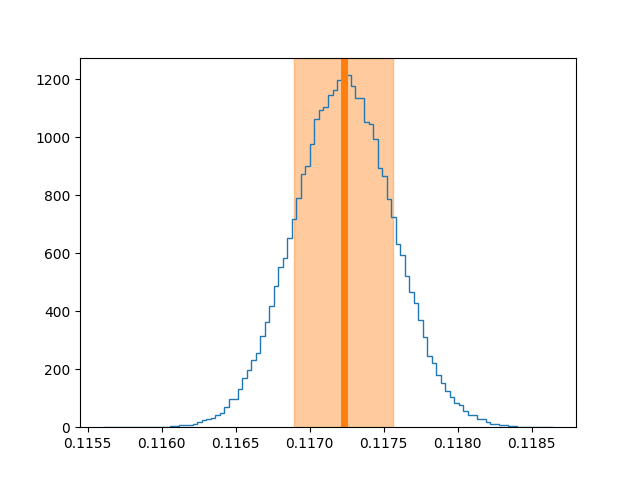

0.11722862313123726 +/- 0.0003334662184320553


In [9]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b40["g_im"] = m
resdict_L6b40["err_g_im"] = s

<IPython.core.display.Javascript object>


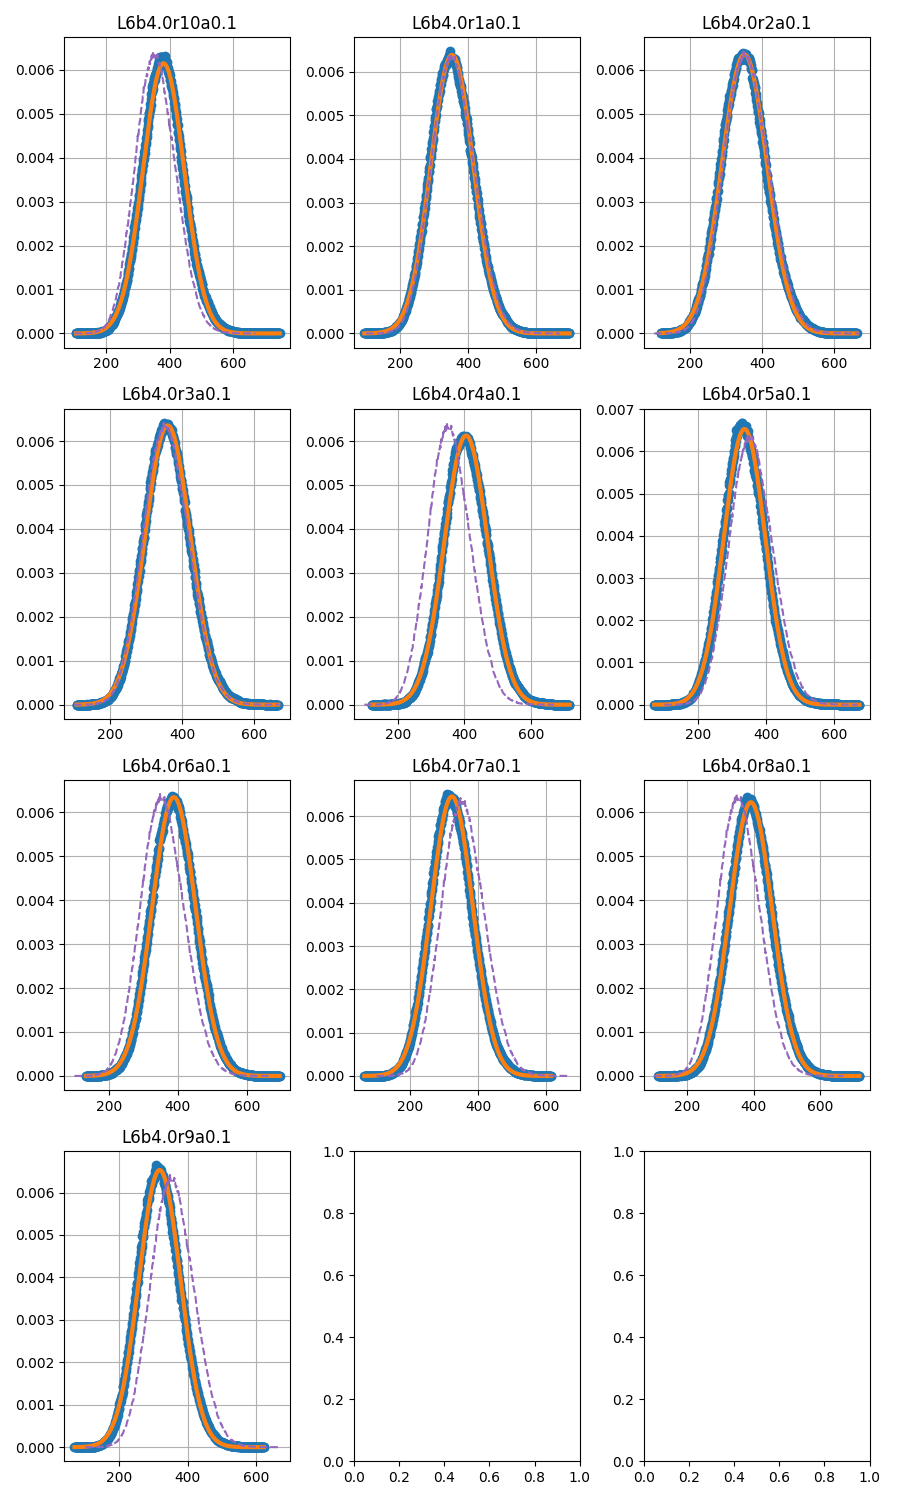

In [52]:
fnames = !ls ../runs/L6b4.0/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b4.0_1.dat'
plot_nmnm(fnames, fname_unif)

### Analyze $L=6$, $\beta=4.5$

In [10]:
resdict_L6b45 = {"L": 6, "beta": 4.5}

reslines = !ls ../runs/L6b4.5/res*
print(reslines)
df = read_res(reslines)
df

['../runs/L6b4.5/res_L6b4.5r10a0.1.dat', '../runs/L6b4.5/res_L6b4.5r1a0.1.dat', '../runs/L6b4.5/res_L6b4.5r2a0.1.dat', '../runs/L6b4.5/res_L6b4.5r3a0.1.dat', '../runs/L6b4.5/res_L6b4.5r4a0.1.dat', '../runs/L6b4.5/res_L6b4.5r5a0.1.dat', '../runs/L6b4.5/res_L6b4.5r6a0.1.dat', '../runs/L6b4.5/res_L6b4.5r7a0.1.dat', '../runs/L6b4.5/res_L6b4.5r8a0.1.dat', '../runs/L6b4.5/res_L6b4.5r9a0.1.dat']


,replica_id,density,err_density,conv_density,g_im,err_g_im,conv_g_im,Z(mln)
0,10,0.176548,0.000393,T,0.173093,0.001959,T,56.518127
1,1,0.167219,0.000319,T,0.159794,0.001966,F,89.079873
2,2,0.165874,0.000338,T,0.154919,0.001312,T,76.791331
3,3,0.169848,0.000329,T,0.161567,0.001702,T,78.858520
4,4,0.184799,0.000544,T,0.184380,0.001887,T,53.465784
5,5,0.160663,0.000462,T,0.147883,0.001416,T,100.252267
6,6,0.181024,0.000457,T,0.180425,0.001976,T,67.024091
7,7,0.155684,0.000272,T,0.138793,0.001171,T,122.756382
8,8,0.181820,0.000565,T,0.181482,0.001545,T,66.709982
9,9,0.154334,0.000523,T,0.137258,0.001579,T,134.391545


<IPython.core.display.Javascript object>


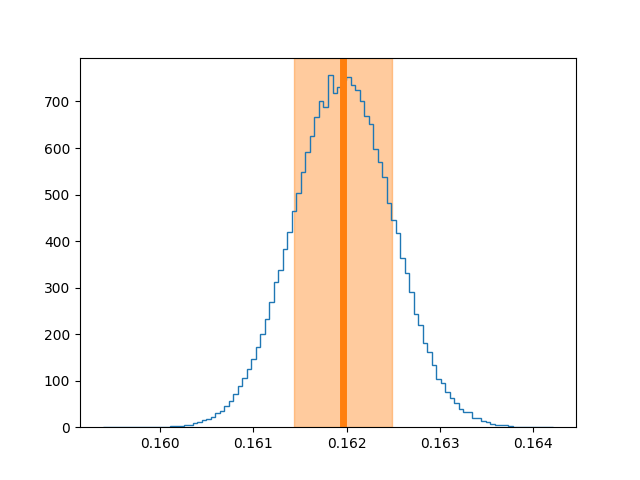

0.16195933205798857 +/- 0.0005283940158537283


In [11]:
samples = resample(df["g_im"], df["err_g_im"])
plt.hist(samples, density=True, bins=100, histtype='step')

m, s = samples.mean(), samples.std()

plt.axvline(m, lw=5, color='C1')
plt.axvspan(m-s, m+s, alpha=0.4, color='C1')

print(m, '+/-', s)
resdict_L6b45["g_im"] = m
resdict_L6b45["err_g_im"] = s

<IPython.core.display.Javascript object>


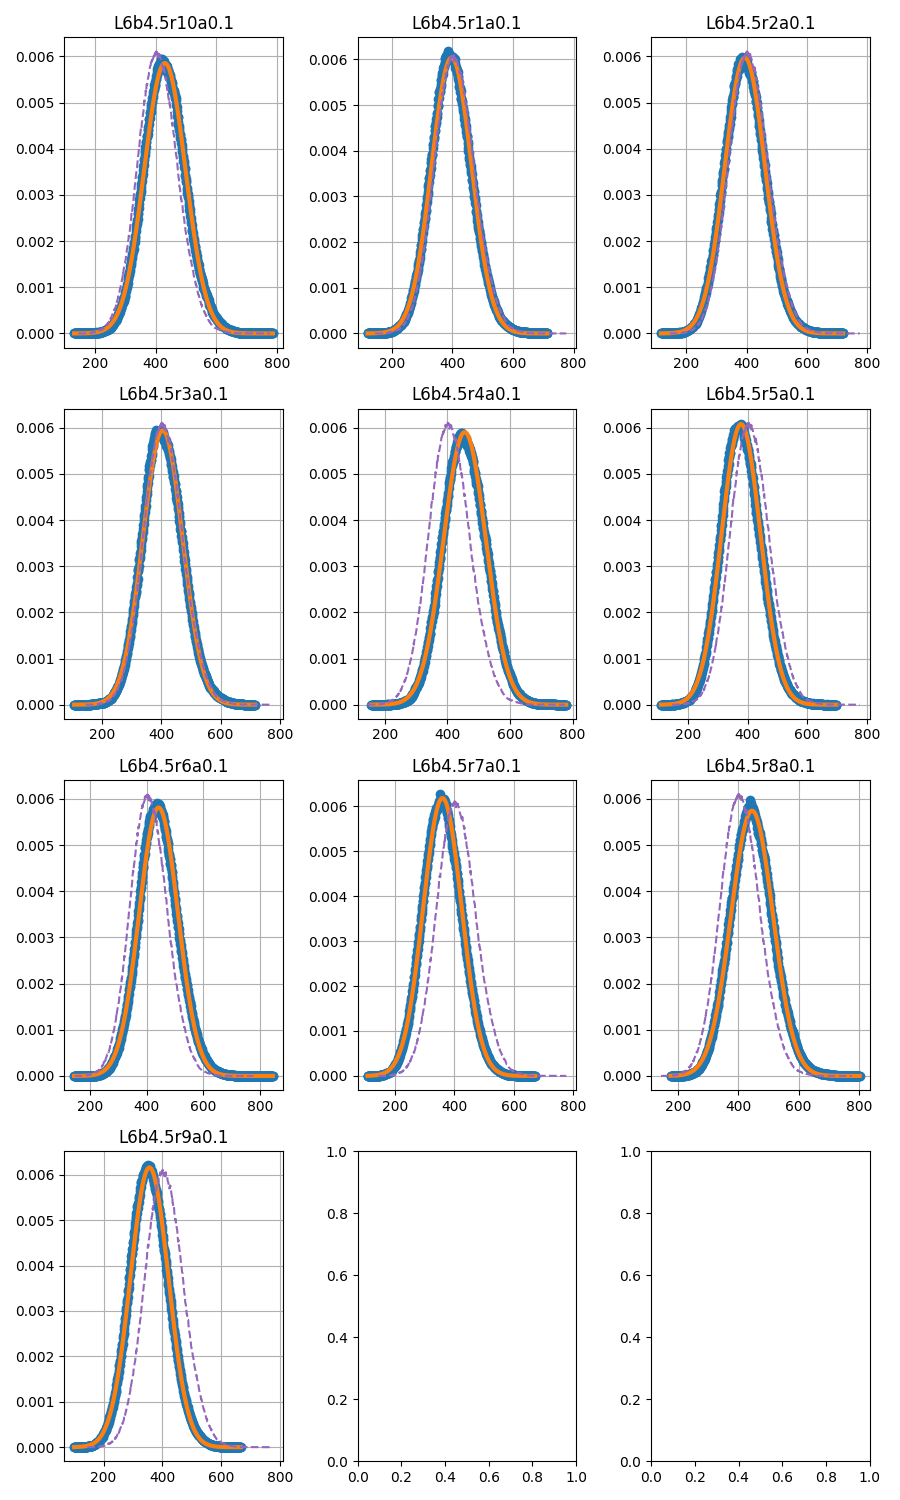

In [53]:
fnames = !ls ../runs/L6b4.5/nmnm*
fname_unif = '../repro_runs/m5.2L6/nmnm_m5.2L6b4.5_1.dat'
plot_nmnm(fnames, fname_unif)

## collect L=6 

In [12]:
df = pd.DataFrame([resdict_L6b35, resdict_L6b40, resdict_L6b45])
df

,L,beta,g_im,err_g_im
0,6,3.5,0.072736,0.000177
1,6,4.0,0.117229,0.000333
2,6,4.5,0.161959,0.000528


In [58]:
# SAVE L=6
df.to_csv("m5.2L6_av_replicas.dat")
print(df.to_csv())

,L,beta,g_im,err_g_im
0,6,3.5,0.07273619241738194,0.0001769013784177102
1,6,4.0,0.11722862313123726,0.0003334662184320553
2,6,4.5,0.16195933205798857,0.0005283940158537283



# Compare to the uniform simulations

In [13]:
!ls ../repro_data

fit_tc.ipynb  m5.2.dat	README


In [61]:
df_uniform = pd.read_csv("../repro_data/m5.2.dat", sep="\s+")
df_uniform

,#L,beta,g_im,err_g_im,density,err_density,Z
0,6,3.50,0.07180,0.0004,0.17092,0.000254,275.0
1,6,4.00,0.11677,0.0008,0.16756,0.000500,129.0
2,6,4.50,0.16630,0.0020,0.17051,0.000200,64.0
3,6,5.00,0.19430,0.0019,0.17178,0.000400,40.0
4,8,3.50,0.04631,0.0016,0.16549,0.002000,24.5
5,8,4.00,0.10630,0.0012,0.16300,0.000500,121.0
6,8,4.25,0.13750,0.0020,0.16000,0.000300,128.2
7,8,4.50,0.17200,0.0015,0.16190,0.000400,88.0
8,8,5.00,0.22460,0.0120,0.16665,0.002000,2.0
9,12,4.20,0.12200,0.0032,0.15770,0.000800,58.0


<IPython.core.display.Javascript object>


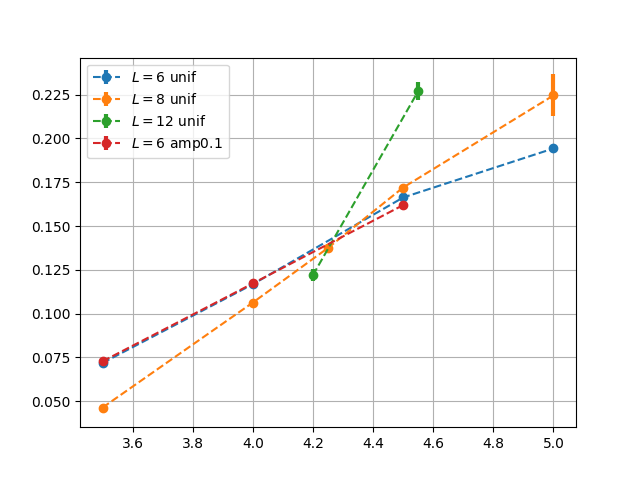

In [62]:
fig, ax = plt.subplots(1, 1)

for L, grp in df_uniform.groupby("#L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o--', elinewidth=3, label=r"$L=%s$ unif" % L)
    
for L, grp in df.groupby("L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o--', elinewidth=3, label=r"$L=%s$ amp0.1" % L)

ax.legend(loc='best')
plt.grid(True)
plt.show()